In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import array

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib
import os

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/haram4th/ablearn/main/hotel_review_75000.csv")
data.head(2)

,Unnamed: 0.1,Unnamed: 0,hotelId,hotelName,tripType,tripTypeText,reviewDate,rating,description,isKorNot
0,0,356,105343,서울 웨스틴조선호텔 (The Westin Chosun Seoul),family,1박 가족 여행,2019년 1월 26일,10.0,직원들 서비스나 마인드 완벽합니다 다만 노후된 시설과 좁은 라운지가 호텔 이름에 비...,True
1,1,357,105343,서울 웨스틴조선호텔 (The Westin Chosun Seoul),family,1박 가족 여행,2019년 2월 4일,10.0,웨스틴조선은 모든면에서 최고의 숙소라고 생각합니다 분위기 편의성 직원친절도까지 모두...,True


In [4]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'hotelId', 'hotelName', 'tripType',
       'tripTypeText', 'reviewDate', 'rating', 'description', 'isKorNot'],
      dtype='object')

In [5]:
data = data[['rating', 'description']]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       75000 non-null  float64
 1   description  75000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.1+ MB


* rating 8 이상이면 긍정 1, 미만은 부정 0으로 해서 target 컬럼 생성
* description 컬럼 토크나이징, 시퀀스로 변환, 임베딩
* train, valid, test로 데이터 분할
* 딥러닝 네트워크 생성 후 분석
* early_stopping, modelcheckpoint 
* 그래프로 loss 출력

In [7]:
result = []
for i in data['rating']:
    if i >=8:
        result.append(1)
    else:
        result.append(0)

In [8]:
data['target'] = result

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       75000 non-null  float64
 1   description  75000 non-null  object 
 2   target       75000 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [10]:
data.head()

,rating,description,target
0,10.0,직원들 서비스나 마인드 완벽합니다 다만 노후된 시설과 좁은 라운지가 호텔 이름에 비...,1
1,10.0,웨스틴조선은 모든면에서 최고의 숙소라고 생각합니다 분위기 편의성 직원친절도까지 모두...,1
2,10.0,서울시내에서 호캉스를 누릴 수 있는 곳아침 뷔페가 맛있는 곳룸서비스가 좋았음요구사항...,1
3,10.0,가격에 맞게 만족했습니다,1
4,10.0,처음 세명으로 셋팅 되어있지 않은점 빼고는 직원들의 친절도 및 서비스는 모두 맘에 ...,1


In [12]:
def token_text(text):
        token = Tokenizer(lower = False)
        pre_text = []
        pre_text.append("".join(text))
        token.fit_on_texts(pre_text)
        return token.word_index

In [28]:
token = Tokenizer(lower=False)
token.fit_on_texts(data["description"])


In [30]:
x = token.texts_to_sequences(data["description"])

In [32]:
max_length = max(len(i)for i in x)

In [53]:
max_length

377

In [34]:
padded_x = pad_sequences(x, max_length)

In [49]:
padded_x

array([[     0,      0,      0, ...,    101,     83,   2604],
       [     0,      0,      0, ...,  67078,     31,   3858],
       [     0,      0,      0, ...,  67082,    665,   4111],
       ...,
       [     0,      0,      0, ...,    195,  42071,  39796],
       [     0,      0,      0, ..., 261891,    502,    437],
       [     0,      0,      0, ...,   3199,   8900,     64]])

In [50]:
classes

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [37]:
classes = data["target"]

In [39]:
classes = np.array(classes)

In [40]:
word_size = len(token.word_index) + 1

In [51]:
# 단어 임베딩을 포함해서 딥러닝 모델 생성
model = Sequential()
model.add(Embedding(word_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 377, 8)            2095152   
                                                                 
 flatten_1 (Flatten)         (None, 3016)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3017      
                                                                 
Total params: 2,098,169
Trainable params: 2,098,169
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(padded_x, classes, epochs=20)
print('Accuracy: ', model.evaluate(padded_x, classes)[1])

Epoch 1/20
2344/2344 [==============================] - 17s 7ms/step - loss: 0.3566 - accuracy: 0.8436
Epoch 2/20
2344/2344 [==============================] - 16s 7ms/step - loss: 0.2118 - accuracy: 0.9188
Epoch 3/20
2344/2344 [==============================] - 16s 7ms/step - loss: 0.1259 - accuracy: 0.9560
Epoch 4/20
2344/2344 [==============================] - 16s 7ms/step - loss: 0.0762 - accuracy: 0.9758
Epoch 5/20
2344/2344 [==============================] - 17s 7ms/step - loss: 0.0500 - accuracy: 0.9844
Epoch 6/20
2344/2344 [==============================] - 17s 7ms/step - loss: 0.0354 - accuracy: 0.9893
Epoch 7/20
2344/2344 [==============================] - 16s 7ms/step - loss: 0.0269 - accuracy: 0.9918
Epoch 8/20
2344/2344 [==============================] - 17s 7ms/step - loss: 0.0217 - accuracy: 0.9936
Epoch 9/20
2344/2344 [==============================] - 17s 7ms/step - loss: 0.0182 - accuracy: 0.9943
Epoch 10/20
2344/2344 [==============================] - 17s 7ms/step - l

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_x, classes, test_size=0.4,random_state=7)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5,random_state=7)

In [55]:
word_size

261894

In [56]:
# 단어 임베딩을 포함해서 딥러닝 모델 생성
model = Sequential()
model.add(Embedding(word_size, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 377, 32)           8380608   
                                                                 
 flatten_2 (Flatten)         (None, 12064)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 12065     
                                                                 
Total params: 8,392,673
Trainable params: 8,392,673
Non-trainable params: 0
_________________________________________________________________


In [59]:
modelpath='./model/{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [60]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
print('Accuracy: ', model.evaluate(X_test, y_test)[1])

Epoch 1/5
1407/1407 [==============================] - 25s 18ms/step - loss: 0.3628 - accuracy: 0.8418 - val_loss: 0.3171 - val_accuracy: 0.8615
Epoch 2/5
1407/1407 [==============================] - 25s 17ms/step - loss: 0.1801 - accuracy: 0.9337 - val_loss: 0.3370 - val_accuracy: 0.8647
Epoch 3/5
1407/1407 [==============================] - 25s 17ms/step - loss: 0.0805 - accuracy: 0.9750 - val_loss: 0.4042 - val_accuracy: 0.8519
Epoch 4/5
1407/1407 [==============================] - 24s 17ms/step - loss: 0.0413 - accuracy: 0.9884 - val_loss: 0.4665 - val_accuracy: 0.8451
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.5304 - accuracy: 0.8380
Accuracy:  0.8379999995231628


In [22]:
data["description"]

0        직원들 서비스나 마인드 완벽합니다 다만 노후된 시설과 좁은 라운지가 호텔 이름에 비...
1        웨스틴조선은 모든면에서 최고의 숙소라고 생각합니다 분위기 편의성 직원친절도까지 모두...
2        서울시내에서 호캉스를 누릴 수 있는 곳아침 뷔페가 맛있는 곳룸서비스가 좋았음요구사항...
3                                            가격에 맞게 만족했습니다
4        처음 세명으로 셋팅 되어있지 않은점 빼고는 직원들의 친절도 및 서비스는 모두 맘에 ...
                               ...                        
74995    조식과 스탠더드 하프전망 신청해서  1박 했는데요ᆢ너무 좋아요ᆢ다만 가격이 좀 나가...
74996    객실은 깔끔하고 에메니티도 딱 필요한만큼 있었습니다 5분거리에 중앙시장이 있어 쇼핑...
74997    배드가 좋고 조용해서 좋았습니다찬바람이 좀 들어와서 난방기를 12시간 정도 돌려야 ...
74998    우선 위치가 너무 좋았고 숙소에 짐을 놓고 걸어서 주변 가볼곳도 있고 먹거리도 맛있...
74999    주차장이 부족해서 다른데에 주차했는데 아침에 이동해달라는 전화가 와서 다소 불쾌했슴...
Name: description, Length: 75000, dtype: object

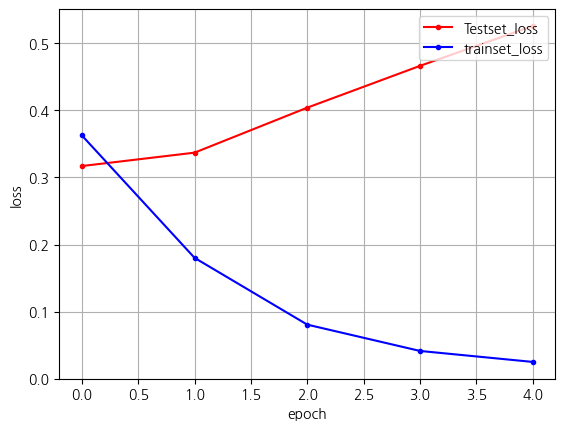

In [62]:
y_val_loss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_val_loss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='trainset_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
text = '해보지 않으면 해낼 수 없다.'

In [ ]:
result = text_to_word_sequence(text)
print("원문: ", text)
print("토큰화: ", result) # 토큰, 코퍼스(corpus)

In [ ]:
# 단어 빈도수 세기
docs = ['먼저 텍스트의 각 단어를 나누어 토큰화 합니다.',
       '텍스트의 단어로 토큰화해야 딥러닝에서 인식됩니다.',
        '토큰화한 결과는 딥러닝에서 사용할 수 있습니다.']

# 토크나이즈 사용법

In [ ]:
# 문장 토큰화 하기
token = Tokenizer(lower=False)
token.fit_on_texts(docs)

In [ ]:
print('단어 카운트: ', token.word_counts)

In [ ]:
print('문장 카운트: ', token.document_count)

In [ ]:
print('각 단어가 몇 개의 문장에 포함되어 있는가? ', token.word_docs)

In [ ]:
print('각 단어에 매겨진 인덱스: ', token.word_index)

# 단어의 원-핫 인코딩

In [ ]:
text = '오랫동안 꿈꾸는 이는 그 꿈을 닮아간다'
token = Tokenizer(lower=False)
token.fit_on_texts([text])
print(token.word_index)

In [ ]:
# 단어를 벡터로 변환
x = token.texts_to_sequences([text])

In [ ]:
len(token.word_index)

In [ ]:
# 인덱스에 1을 추가해서 원-핫 인코딩 배열 만들기
word_size = len(token.word_index) + 1 # +1 해주는 이유는 결과 앞에 0 안들어가서 잘려서 들어감

In [ ]:
x = to_categorical(x, num_classes=word_size)
print(x)

# 텍스트를 읽고 긍정, 부정 예측하기

In [ ]:
docs = ['너무 재밌네요', '최고에요', '참 잘 만든 영화예요', '추천하고 싶은 영화입니다.',
       '한번 더 보고싶네요', '글쎄요', '별로에요', '생각보다 지루하네요', '연기가 어색해요', '재미없어요']

# 긍정리뷰는 1, 부정리뷰는 0으로 클래스 지정
classes = array([1,1,1,1,1,0,0,0,0,0])

In [ ]:
# 토큰화
token = Tokenizer(lower=False)
token.fit_on_texts(docs)
print(token.word_index)

In [ ]:
# 원핫인코딩
x = token.texts_to_sequences(docs)
print(x)

In [ ]:
# 패딩 추가 pad_sequences(데이터, 가장 긴 문장의 길이)
padded_x = pad_sequences(x, 4)
print("패딩 결과", padded_x)

In [ ]:
# 임베딩에 입력된 단어의 수 지정
word_size = len(token.word_index) + 1

In [ ]:
# 단어 임베딩을 포함해서 딥러닝 모델 생성
model = Sequential()
model.add(Embedding(word_size, 8, input_length=4))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(padded_x, classes, epochs=20)
print('Accuracy: ', model.evaluate(padded_x, classes)[1])